## GAT

In [1]:
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import cudf
import torch

data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/home/dwalke/git/sbc/dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


In [2]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))

In [3]:
max_Id = data["Id"].unique().max()

In [4]:
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)

In [5]:
data = pd.concat((data, gw_data))
data = cudf.from_pandas(data)

In [6]:
data = data.sort_values("Id")

In [7]:
unique_ids = data["Id"].unique()

In [8]:
data = data.reset_index(drop=True)

In [9]:
data.pop("index")

0          665587
1          665588
2          665589
3          665590
4          665592
            ...  
1819430    665580
1819431    665582
1819432    665581
1819433    665586
1819434    665585
Name: index, Length: 1819435, dtype: int64

In [10]:
data = data.sort_values(["Id", "Time"])

In [11]:
data = data.reset_index(drop=True)

## Creating edge index

In [12]:
# import numpy as np
# import cupy as cp
# import time

# source_edge_index = np.array([], dtype= cp.int32)
# target_edge_index = np.array([], dtype= cp.int32)

# start = time.time()
# j = 0
# for Id, group in data.groupby("Id"):
#     indices = group.index
#     offset = indices[0]
#     num_nodes = len(indices)
#     edge_index = torch.zeros((2, sum(range(num_nodes + 1))), dtype=torch.long)+offset

#     ## Self edges
#     edge_index[:, 0:num_nodes] = (torch.arange(num_nodes) + offset).view(1, -1)
#     idx = num_nodes
#     for i in range(1, num_nodes):
#         edge_index[1, idx:idx + i] = i+offset
#         edge_index[0, idx:idx + i] = torch.arange(i)+offset
#         idx += i
    
#     source_edge_index = np.concatenate((source_edge_index, edge_index[0, :].numpy()))
#     target_edge_index = np.concatenate((target_edge_index, edge_index[1, :].numpy()))
#     j+=1
#     if j % 1000 == 0:
#         print(f"{str(j / unique_ids.shape[0] * 100)} %")

# print(time.time() - start )
# print(source_edge_index.shape)
# print(target_edge_index.shape)

# edge_index = np.asarray([np.asarray(source_edge_index), np.asarray(target_edge_index)])
# edge_index = torch.tensor(edge_index)
# pd.DataFrame(edge_index.numpy().transpose()).to_csv("dir_edge_index_sorted_ids_w_gw_corr.csv", index=False)

In [13]:
import torch

In [43]:
import torch
edge_index = torch.tensor(pd.read_csv("dir_edge_index_sorted_ids_w_gw_corr.csv", header=None, skiprows=1).values.transpose(), dtype=torch.long)

In [15]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

In [16]:
data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d = len(FEATURES), n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

In [18]:
X_features = torch.tensor(data[FEATURES].values.get()).type(torch.float32)
y = torch.tensor(data["Label"].values.get()).type(torch.long)

In [19]:
from dataAnalysis.FeatureImportance import normalize

X_features = normalize(X_features)

## Creating positional encodings

In [20]:
# import numpy as np
# import time

# pos_encodings = None

# start = time.time()
# i = 0
# final_shape = 0
# for Id, group in data.groupby("Id"):
#     encoding = getPositionEncoding(group.shape[0])
# #     sorted_group = group.reset_index().sort_values("Time")
# #     encoding = encoding[sorted_group.index.to_numpy()]
#     final_shape += group.shape[0]
#     pos_encodings = encoding if pos_encodings is None else np.concatenate((pos_encodings, encoding), axis=0)
#     i+=1
#     if i % 1000 == 0:
#         print(f"{str(i / unique_ids.shape[0] * 100)} %")

# print(pos_encodings.shape[0] == final_shape)
# pd.DataFrame(pos_encodings).to_csv("pos_encodings_new_w_gw_corr.csv", index=False)

In [21]:
pos_encodings = pd.read_csv("pos_encodings_new_w_gw_corr.csv", header=None, skiprows=1)

In [22]:
pos_encodings = pos_encodings.values

In [23]:
X_features

tensor([[ 1.1067, -0.9899,  0.4046,  ...,  0.3607, -0.4256, -0.6549],
        [-1.2956, -0.9899,  2.0656,  ...,  2.3851, -1.3951, -0.3717],
        [-0.6404,  1.0102,  0.8033,  ...,  0.3729,  0.1943,  0.5042],
        ...,
        [-0.1490, -0.9899,  0.4046,  ...,  0.5314, -0.1713, -0.1417],
        [ 0.0693,  1.0102,  1.0690,  ...,  0.8973,  0.2102,  0.8493],
        [ 0.0693,  1.0102,  1.4676,  ...,  1.3851,  0.4804,  1.1501]])

In [24]:
X_new_features = X_features + pos_encodings

In [25]:
X_new_features.shape

torch.Size([1819435, 7])

In [26]:
def ratio_bool_switch(tensor, ratio = 0.8):
    random = np.random.uniform(0, 1 ,tensor.shape[0])
    val_ratio_mask = (random >= ratio)
    train_ratio_mask = (random < ratio)
    val_mask = np.logical_and(tensor.tolist(), val_ratio_mask.tolist())
    train_mask = np.logical_and(tensor.tolist(), train_ratio_mask.tolist())
    return torch.from_numpy(train_mask).type(torch.bool), torch.from_numpy(val_mask).type(torch.bool)

In [27]:
from torch_geometric.utils import to_undirected

# edge_index = to_undirected(edge_index)

In [113]:
rev_edge_index = torch.zeros_like(edge_index)
index = torch.LongTensor([1,0])
rev_edge_index[index] = edge_index

In [114]:
rev_edge_index

tensor([[      0,       1,       2,  ..., 1819433, 1819434, 1819434],
        [      0,       1,       2,  ..., 1819433, 1819434, 1819433]])

In [87]:
from torch_geometric.data import Data

train_mask_ser = data["Set"] != "Validation"
train_mask, val_mask = ratio_bool_switch(train_mask_ser.values)
test_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values.get(), (data["Center"] == "Leipzig").values.get())).type(torch.bool)
test_gw_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values.get(), (data["Center"] == "Greifswald").values.get())).type(torch.bool)
graph = Data(x=X_new_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=edge_index,
             test_gw_mask = test_gw_mask)

In [178]:
graph = Data(x=X_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=rev_edge_index,
             test_gw_mask = test_gw_mask)

In [179]:
test_gw_mask.sum() + test_mask.sum()+val_mask.sum()+train_mask.sum()

tensor(1819435)

In [180]:
graph.edge_index

tensor([[      0,       1,       2,  ..., 1819433, 1819434, 1819434],
        [      0,       1,       2,  ..., 1819433, 1819434, 1819433]])

In [181]:
graph = graph.cpu()

In [182]:
graph

Data(x=[1819435, 7], edge_index=[2, 7259211], y=[1819435], train_mask=[1819435], test_mask=[1819435], val_mask=[1819435], test_gw_mask=[1819435])

In [183]:
from torch_geometric.loader import NeighborLoader

kwargs = {
    "num_neighbors":[-1] * 2,
    "batch_size":50_000
}
loader = NeighborLoader(
    graph,
    input_nodes=graph.train_mask,
    **kwargs
)
val_loader = NeighborLoader(
    graph,
    input_nodes=graph.val_mask,
    **kwargs
)

In [184]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

# graph = graph.to(device)
WEIGHT = torch.tensor([664*2/3])#
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:2


In [185]:
graph.val_mask.sum()

tensor(202361)

In [186]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, global_add_pool
from torch.nn import Linear
import torch
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        HEADS = 5
        
        conv_1= GATConv(input_dim, hidden_dim,heads=HEADS, add_self_loops = False)
        conv_end = GATConv((-1,-1), out_channels,add_self_loops = False)
        
        self.conv_1 = conv_1
        self.conv_end = conv_end
        

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = x.type(torch.float)
        x = self.conv_1(x, edge_index) 
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

In [187]:
import torch 
from tqdm.notebook import tqdm
from dataAnalysis.Metrics import Evaluation

class ModelWrapper():
    def __init__(self, graph):
        self.LEARNING_RATE = 3e-4
        self.MAX_EPOCHS = 10000 #40000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
        self.graph = graph
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5  
        self.val_loss = []
        self.train_loss = []
        self.epochs = self.MAX_EPOCHS
        
    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(val_loader):
                graph = graph.to(device)
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.val_mask], graph.y[graph.val_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.val_loss.append(avg_loss)
            if avg_loss > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = avg_loss

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            acc_loss = 0
            batch_size = 0
                
#             if epoch == 10:
#                 self.change_lr(1e-5)
#                 self.plot_loss()
#                 self.evaluate()
#             if epoch == 20:
#                 self.change_lr(5e-4)
#                 self.plot_loss()
#                 self.evaluate()
#             if epoch == 30:
#                 self.change_lr(1e-4)
#                 self.plot_loss()
#                 self.evaluate()
            for batch, graph in enumerate(loader):
                graph = graph.to(device)
                self.model.train()
                self.optimizer.zero_grad()
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.train_mask], graph.y[graph.train_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(acc_loss/batch_size)
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                self.epochs = epoch + 1
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(range(len(self.train_loss)), self.train_loss, 'g', label='Training loss')
        plt.plot(range(len(self.val_loss)), self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def evaluate(self):
        self.model = self.model.cpu()
        self.graph = self.graph.cpu()
        y_dict = Evaluation.create_y_dict(self.model.predict(self.graph, self.graph.test_mask), self.model.predict_proba(self.graph, self.graph.test_mask) , self.graph.y[self.graph.test_mask])
        y_dict_gw = Evaluation.create_y_dict(self.model.predict(self.graph, self.graph.test_gw_mask), self.model.predict_proba(self.graph, self.graph.test_gw_mask) , self.graph.y[self.graph.test_gw_mask])
        eval_df = Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw)
        print(eval_df)
        self.model = self.model.to(device)


In [188]:
model_wrapper = ModelWrapper(graph)
model_wrapper.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Breaked at 5097


In [200]:
graph

Data(x=[1819435, 7], edge_index=[2, 7259211], y=[1819435], train_mask=[1819435], test_mask=[1819435], val_mask=[1819435], test_gw_mask=[1819435])

In [215]:
graph.test_gw_mask.sum() == (data["Center"] == "Greifswald").sum()

tensor(True)

In [219]:
graph.test_mask.sum() == (np.logical_and(data["Center"] == "Leipzig", data["Set"] == "Validation")).sum()

tensor(True)

In [220]:
(graph.train_mask.sum() + graph.val_mask.sum()) == (np.logical_and(data["Center"] == "Leipzig", data["Set"] == "Training")).sum()

tensor(True)

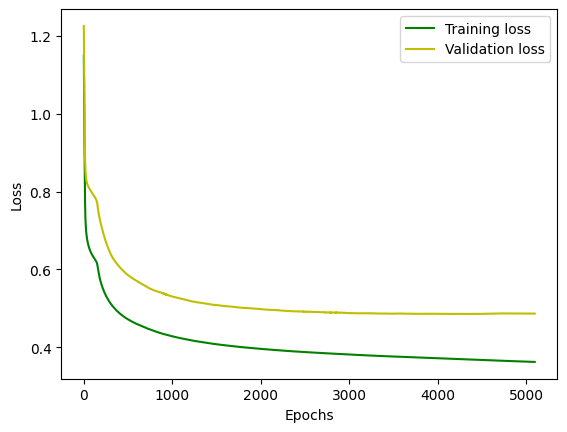

In [202]:
model_wrapper.plot_loss()

In [203]:
model = model_wrapper.get_model()
graph = graph.cpu()
model = model.cpu()

In [204]:
#torch.save(model.state_dict(), "directed_gat_corr.pt")

In [221]:
from dataAnalysis.Metrics import Evaluation

y_dict = Evaluation.create_y_dict(model.predict(graph, graph.test_mask), model.predict_proba(graph, graph.test_mask) , graph.y[graph.test_mask])
y_dict_gw = Evaluation.create_y_dict(model.predict(graph, graph.test_gw_mask), model.predict_proba(graph, graph.test_gw_mask) , graph.y[graph.test_gw_mask])

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.099420,0.918236,0.491893,0.026460,0.952656,0.042833
1,Greifswald,0.080521,0.899216,0.482035,0.017185,0.951471,0.031865


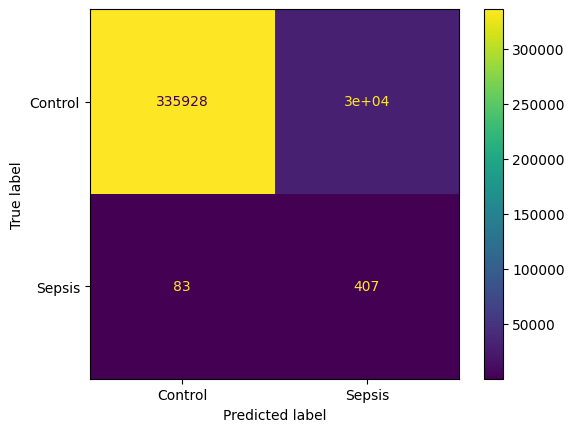

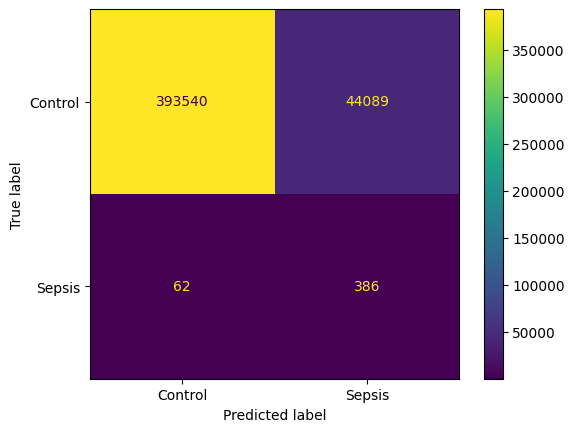

In [222]:
from dataAnalysis.Metrics import Evaluation

Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, graph.test_mask), graph.y[graph.test_mask])
Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, graph.test_gw_mask), graph.y[graph.test_gw_mask])
Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw)

In [224]:
from dataAnalysis.Metrics import Evaluation

y_dict_train = Evaluation.create_y_dict(model.predict(graph, graph.train_mask), model.predict_proba(graph, graph.train_mask) , graph.y[graph.train_mask])
y_dict_val = Evaluation.create_y_dict(model.predict(graph, graph.val_mask), model.predict_proba(graph, graph.val_mask) , graph.y[graph.val_mask])

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.115465,0.919664,0.495316,0.03254,0.969094,0.055477
1,Greifswald,0.108941,0.919001,0.494013,0.03029,0.954230,0.048976


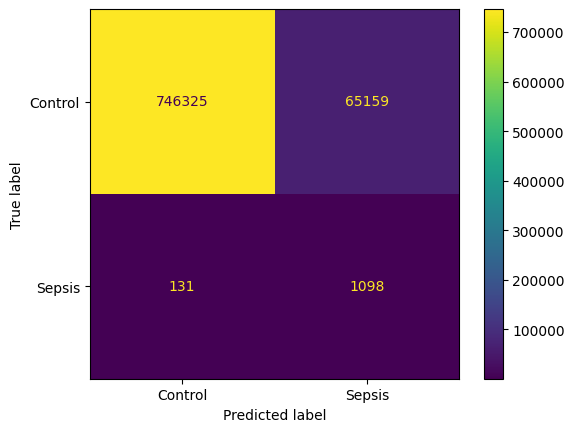

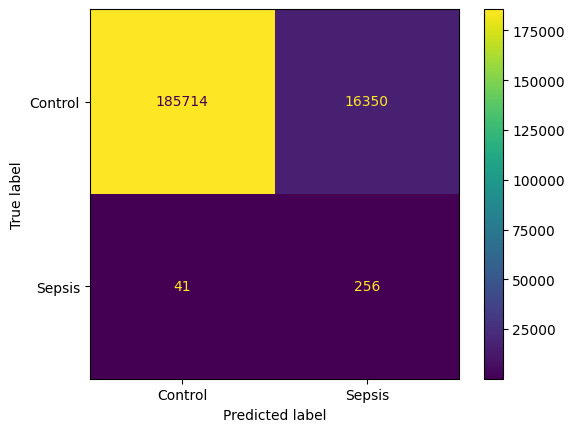

In [225]:
from dataAnalysis.Metrics import Evaluation

Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, graph.train_mask), graph.y[graph.train_mask])
Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, graph.val_mask), graph.y[graph.val_mask])
Evaluation.get_df_metrics_from_pred(y_dict_train, y_dict_val)

In [ ]:
from IPython.display import Audio
sound_file = './finish_sound.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
##TODO:
# - change weight
# - gradients as features
# - different learning rate and number of layers
# - general architecture- less neurons but linear layer before and after convs? 
#       -adding hidden layers with each others for more stable training (guaranteed only when hidden dim is euqal betwene layers)
# - GATv2
# - MIMIC und Greifswald
# - more features

In [ ]:
import time

for i in range(10000):
    time.sleep(60)
    print("Sleeping")

In [ ]:
for column in df.columns:
    df[] df[column].mean()